## 初始状态项目结构
```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images
        ├── test_captions.json
        └── train_captions.json
```

如果不按照此代码框架运行，可能会出问题，或者也可以根据你自己的文件分布，更改`ipynb`代码。

我们首先进行数据集的处理工作。

## 数据集处理方案

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。

- 对于文本描述，我们首先构建词典，然后根据词典将文本描述转化为向量。
- 对于图像，我们这里仅记录文件路径。在模型训练与测试阶段，再进行读取。

下面我们开始准备数据集的切片，把训练集切分为训练集、验证集两个部分。

In [108]:
import os
import json
import random
from typing import List, Dict, Tuple, Optional

import torch

code_running_path = os.getcwd()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"The code is running in path: `{code_running_path}`")
print(f"Device of your machine: {device}: {torch.cuda.get_device_name(0)}")

base_path = "../data/deepfashion_multimodal/"

dataset_path = {
  "images": os.path.join(base_path, "images"),
  "train_label": os.path.join(base_path, "train_captions.json"),
  "test_label": os.path.join(base_path, "test_captions.json")
}


def split_dataset(dataset_path: Dict[str, str]):
    with open(dataset_path["train_label"]) as f:
        train_labels = json.load(f)
    with open(dataset_path["test_label"]) as f:
        test_labels = json.load(f)
    train_labels_name = list(train_labels.keys())
    
    # randomly choose 20% of the training data as validation data
    random.shuffle(train_labels_name)
    val_labels_name = train_labels_name[:int(len(train_labels_name) * 0.2)]
    train_labels_name = train_labels_name[int(len(train_labels_name) * 0.2):]
    test_labels_name = list(test_labels.keys())
    
    # 依据划分的数据集构建 dict
    def make_dataset_dict(image_names: List[str], labels: Dict[str, str]):
        return {k: labels[k] for k in image_names if k in labels.keys()}
    
    train_data_dict = make_dataset_dict(train_labels_name, train_labels)
    val_data_dict = make_dataset_dict(val_labels_name, train_labels)
    test_data_dict = make_dataset_dict(test_labels_name, test_labels)
    
    return train_data_dict, val_data_dict, test_data_dict
    
# split_dataset(dataset_path)

The code is running in path: `/d_workspace/Python/NNDL/code`
Device of your machine: cuda:0: NVIDIA GeForce RTX 4070 Laptop GPU


下面开始整理数据集，按照先前的思路，首先统计每一个单词出现的次数，以此作为后续编码文本的重要依据。

In [109]:
from collections import Counter
from PIL import Image

def encode_vocab(min_word_freq=5):
    output_dir = os.path.join(base_path, 'output')
    
    train_output_path = os.path.join(output_dir, 'train_data.json')
    val_output_path = os.path.join(output_dir, 'val_data.json')
    test_output_path = os.path.join(output_dir, 'test_data.json')
    
    if os.path.exists(output_dir):
        return train_output_path, val_output_path, test_output_path
    else:
        os.mkdir(output_dir)
    
    # first we prepare the vocab
    train_data_dict, val_data_dict, test_data_dict = split_dataset(dataset_path)
    vocab = Counter()
    for _, v in train_data_dict.items():
        tokens = v.split()  # split by whitespace
        tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
        vocab.update(tokens)
        
        
    words = [w for w, c in vocab.items() if c >= min_word_freq]
    vocab = {w: idx + 1 for idx, w in enumerate(words)} # update the vocab reversely
    
    vocab['<pad>'] = 0
    
    # Note that the operation below will automatically increase the vocab length
    vocab['<unk>'] = len(vocab) 
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)
    with open(os.path.join(output_dir, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw, indent=4)    # write it into json file
        
        
    # then we encode the captions
    def encode_caption(dataset: Dict[str, str]):
        img_paths = [i_path for i_path in dataset.keys()]
        descrips = [descrip for descrip in dataset.values()]
        
        readable_paths = []
        enc_captions = []
        
        for img_path, descrip in zip(img_paths, descrips):
            # check if the image is OK
            try:
                img_path_ = os.path.join(base_path + 'images/', img_path)
                img = Image.open(img_path_)
            except:
                raise Exception(f"Image `{img_path}` cannot be openned!")
            readable_paths.append(img_path_)
            tokens = descrip.split()
            tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
            
            enc = [vocab['<start>']] + [vocab.get(t, vocab['<unk>']) for t in tokens] + [vocab['<end>']]
            enc_captions.append(enc)
            
        assert len(readable_paths) == len(enc_captions)
        data = {'IMAGES': readable_paths, 
                'CAPTIONS': enc_captions}
        return data
    
    train_data = encode_caption(train_data_dict)
    with open(os.path.join(output_dir, 'train_data.json'), 'w') as fw:
        json.dump(train_data, fw)
        
    val_data = encode_caption(val_data_dict)
    with open(os.path.join(output_dir, 'val_data.json'), 'w') as fw:
        json.dump(val_data, fw)
        
    test_data = encode_caption(test_data_dict)
    with open(os.path.join(output_dir, 'test_data.json'), 'w') as fw:
        json.dump(test_data, fw)
        
    return train_output_path, val_output_path, test_output_path
        
encode_vocab(min_word_freq=3)

('../data/deepfashion_multimodal/output/train_data.json',
 '../data/deepfashion_multimodal/output/val_data.json',
 '../data/deepfashion_multimodal/output/test_data.json')

至此我们的项目架构已经变成了：

```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images (hidden by .gitignore)
        ├── output
        |   ├── test_data.json
        |   ├── train_data.json
        |   ├── val_data.json
        |   └── vocab.json
        |
        ├── test_captions.json
        └── train_captions.json
```

下面对上述数据集处理结果开始进行验证，展示其中一条数据，验证数据的格式是否与我们想象的一致。

<start> this woman wears a short-sleeve t-shirt with pure color patterns and a medium pants the t-shirt is with cotton fabric the neckline of the t-shirt is round the pants are with cotton fabric and pure color patterns there is an accessory on her wrist the lady wears a ring <end>
The max length of captions is 90. The avg length is 52.33874938453963


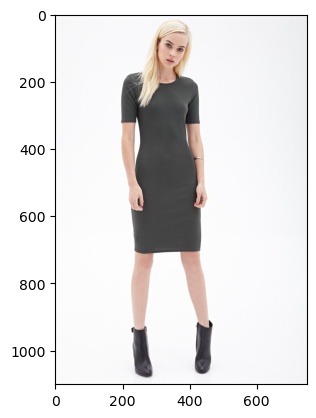

In [110]:
from matplotlib import pyplot as plt

# 读取词典和验证集
with open('../data/deepfashion_multimodal/output/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word, idx in vocab.items()}

with open('../data/deepfashion_multimodal/output/val_data.json', 'r') as f:
    data = json.load(f)
    
# 展示第14张图片
test_number_index = 14
content_img = Image.open(data['IMAGES'][test_number_index])
plt.imshow(content_img)

print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][test_number_index]]))

# 统计最长的caption长度，以及平均长度
max_length = 0
avg_length = 0
for item in data['CAPTIONS']:
    leng = len(item)
    avg_length += leng
    if leng > max_length:
        max_length = leng
        
print(f"The max length of captions is {max_length}. The avg length is {avg_length / len(data['CAPTIONS'])}")

下面我们开始组织训练数据集，使用`torch`中的`dataset`来自定义我们的数据集，便于后续训练使用Dataloader

In [111]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class DeepfashionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 dataset_type: str = 'train', 
                 max_len=80, 
                 transform=None):
        """
        @param:
            dataset_path：json格式数据文件路径(全路径)
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.dataset_type = dataset_type
        assert self.dataset_type in {'train', 'val', 'test'}
        
        with open(dataset_path, 'r') as f:
            self.data: Dict[str, List[str]] = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab: Dict[str, int] = json.load(f)
            
        self.max_len = max_len
        self.transform = transform
        self.dataset_size = len(self.data['CAPTIONS'])
        
    def __getitem__(self, index) -> Tuple[Image.Image, torch.Tensor, int]:
        img = Image.open(self.data['IMAGES'][index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        caplen = len(self.data['CAPTIONS'][index])
        if caplen > self.max_len:
            caption = torch.LongTensor(self.data['CAPTIONS'][index][:self.max_len])
            caplen = self.max_len
        else:
            caption = torch.LongTensor(self.data['CAPTIONS'][index] + [self.vocab['<pad>']] * (self.max_len - caplen))
            
        return img, caption, caplen
    
    def __len__(self) -> int:
        return self.dataset_size

构建Dataloader

In [112]:
def make_dataloader(data_dir, vocab_path, batch_size, workers=4) -> tuple:
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = DeepfashionDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = DeepfashionDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = DeepfashionDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    

### 定义模型
小组计划完成两条路线的模型框架实现：
+ CNN + GRU实现基本的图像生成编解码框架
+ 网格划分表示 + transformer编码器 + 解码器


#### 1. Implement: CNN + GRU

TODO: finish this part

#### 2. Implement: Region Recognition + Transformer Encoder 2 Decoder

在此处实现 `区域划分 + Transformer Encoder + Decoder`的思路

在这里需要注意的是，“网格” 和 “区域” 并不是同一个意思。

<center> 
    <img src="./jupyter_images/grid_expr.png" height="200">
    <img src="./jupyter_images/region_expr.png" height="200">
    <div>
        左图为网格表示，右图为区域表示
    </div>
</center>

为了更加精准地描述图像，我们选择“区域”描述 + Transformer Encoder与Decoder的路线。

+ 区域描述：使用Resnet做卷积，提取区域特征，卷积层的最后一层输出就是提取的特征
+ Transformer Encoder
+ Transformer Decoder

##### Step 2.1 搭建Image Region Encoder

我们首先来做Resnet的卷积提取特征的工作。在这里我们选用resnet50作为卷积网络即可。

In [113]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ImageRegionEncoder(torch.nn.Module):
    def __init__(self, frozen=False):
        super(ImageRegionEncoder, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]      # delete the last fc layer
        
        self.resnet = torch.nn.Sequential(*modules)
        
        if frozen:
            for p in self.resnet.parameters():
                p.requires_grad = frozen
        
    def forward(self, images):
        features = self.resnet(images)
        return features

从上面的`ImageRegionEncoder`的输出中，因为**移除了最后一个全连接层**， 我们得到的是一个特征图feature map，而不是用于分类的具体特征向量。这个特征图包含了图像的空间特征信息。

有关feature map：输出的形状是一个四维的tensor，具体来说是`[batch_size, Channel, Height, Width]`,
+ batch_size: 每份batch的图像数量
+ channel: 对于resnet50，如果仅仅移除了最后一个全连接层，应该是2048
+ Height, Width: 由图像原尺寸和神经网络架构决定

    + **特征图中的每个元素都是图像某个区域的高维特征表示**。这些特征被用来捕获图像中的重要信息（如边缘、纹理、颜色等）。

在此我们首先对图像的feature_map形状进行查看

In [114]:
model = ImageRegionEncoder(frozen=True).to(device)
model.eval()

train_loader_tmp, _, _ = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                        vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                        batch_size=1)

# Select 8 images from the train_loader
images = []
for i, (image, _, _) in enumerate(train_loader_tmp):
    images.append(image)
    if i == 7:
        break

# Convert the list of images to a tensor
images = torch.cat(images, dim=0)

# Pass the images through the ImageRegionEncoder
features = model(images.to(device))

mid_channels = features.shape[1]
mid_height = features.shape[2]
mid_width = features.shape[3]


在构建 Transformer 编码器之前，有几个关键点需要注意：

1. 特征尺寸调整：Transformer 编码器通常接收一维的序列输入。因此，您可能需要将从 ImageRegionEncoder 得到的二维特征（即卷积特征图）转换为一维序列。这通常通过展平特征图的每个区域或者使用全局平均池化来实现。

2. 位置编码：由于 Transformer 编码器本身不处理序列的顺序信息，因此通常需要加入位置编码（Positional Encoding）以提供位置信息。

##### Step 2.2 对输出的`feature_map`进行处理

In [115]:
import numpy as np

def flatten_feature_map(feature_map: torch.Tensor) -> torch.Tensor:
    batch_size, channels, height, width = feature_map.size()
    feature_map = feature_map.permute(0, 2, 3, 1)  # 将通道移动到最后
    feature_map = feature_map.reshape(batch_size, height * width, channels)
    return feature_map

def positional_encoding(seq_len=mid_height*mid_width, d_model=mid_channels) -> torch.Tensor:
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)] 
        if pos != 0 else np.zeros(d_model) 
        for pos in range(seq_len)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return torch.from_numpy(pos_enc).type(torch.FloatTensor)

##### Step 2.3 搭建Transformer Encoder


In [116]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn

class ImageTransEncoder(nn.Module):
    def __init__(self, feature_size, num_layers, nhead):
        super(ImageTransEncoder, self).__init__()
        self.model_type = 'Transformer'
        
        # 编码器层
        encoder_layers = TransformerEncoderLayer(feature_size, nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for param in self.parameters():
            param.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        output = self.transformer_encoder(src, src_mask)
        return output

在经过Transformer Encoder之后，这些输出特征的形状还是`[batch_size, 49, 2048]`，但是此时的output不仅包含了原始图像特征的信息，还融入了序列中不同元素之间的关系，这是通过Encoder中的自注意力机制实现的。

接下来我们可以开始搭建Transformer Decoder

##### Step 2.4 搭建Transformer Decoder

+ Decoder 的任务：Decoder的主要任务是基于Encoder的输出特征生成文本描述。它通常需要两个输入：一是Encoder的输出特征，二是目前为止已生成的文本序列（在训练时，这通常是真实文本序列的一部分；在推断时，这是之前Decoder步骤生成的文本序列）。

+ Decoder 结构：Transformer Decoder也是由多个相同的层堆叠而成，每层包含自注意力机制、交叉注意力机制（用来关注Encoder的输出）和前馈神经网络。

+ 注意力掩码：在Decoder中，通常需要使用注意力掩码（Attention Mask）来避免在生成某个单词时“看到”未来的单词。这对于训练和生成文本序列尤为重要。

In [117]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class ImageTransDecoder(nn.Module):
    def __init__(self, feature_size, num_layers, nhead, vocab_size):
        super(ImageTransDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, feature_size) # convert each word to a vector
        
        decoder_layer = TransformerDecoderLayer(d_model=feature_size, nhead=nhead)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers)
        
        self.fc_out = nn.Linear(feature_size, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for param in self.parameters():
            param.data.uniform_(-initrange, initrange)

    def forward(self, trg, encode_features, trg_mask):
        trg = self.embedding(trg)
        
        target = trg.transpose(0, 1)  # 转换为 [sequence_length, batch_size, features]
        memory = encode_features.transpose(0, 1)  # 同上
        print(f"target new shape: {target.shape}")
        print(f"memory shape: {memory.shape}")
        print(f"target mask shape: {trg_mask.shape}")
        
        output = self.transformer_decoder(target, memory, trg_mask)
        output = self.fc_out(output)
        return output

##### Step 2.5 组建整体模型

In [118]:
class ImageRegionE2D(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.image_region_encoder = ImageRegionEncoder(frozen=True)
        self.image_trans_encoder = ImageTransEncoder(mid_channels, num_layers=2, nhead=4)
        self.image_trans_decoder = ImageTransDecoder(mid_channels, num_layers=2, nhead=4, vocab_size=len(vocab))
        
    def generate_square_subsequent_mask(self, size):
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask
        
    def forward(self, images: torch.Tensor, captions: torch.Tensor):
        # Assume the images have been transformed and moved to the device
        # and the captions have been padded and moved to the device
        
        # step 1: Image Encoder to get the Region
        features = self.image_region_encoder(images)    # shape: [batch_size, 2048, 7, 7]
        features = flatten_feature_map(features)
        
        pos_enc = positional_encoding(seq_len=mid_height*mid_width, d_model=mid_channels).to(device)
        features = features + pos_enc
        
        # Step 2: Transformer Encoder
        # features shape: [batch_size, 49, 2048]
        features = self.image_trans_encoder(features)
        
        # Step 3: Transformer Decoder
        s_size = captions.size(1)
        trg_mask = self.generate_square_subsequent_mask(s_size).to(device)
        outputs = self.image_trans_decoder(captions, features, trg_mask)
        return outputs

下面开始组织训练框架，需要注意的是，反向传播与误差计算，与模型评估是两个过程。

**反向传播**
+ 损失函数：在训练神经网络时，反向传播的依据是损失函数。对于文本生成任务，常用的损失函数是交叉熵损失（Cross-Entropy Loss）。交叉熵损失衡量的是模型预测的概率分布与真实标签的概率分布之间的差异。

+ 反向传播过程：在每次训练迭代中，您会先进行前向传播来计算损失函数，然后进行反向传播来计算梯度，并更新模型的权重。这个过程是基于损失函数的计算结果进行的。

**模型性能评估**
+ 评估指标：BLEU、ROUGE 等指标用于评估模型的性能，特别是在文本生成任务中。这些指标衡量的是模型生成的文本与参考文本（通常是人类编写的标准答案）之间的相似度。

+ 评估时机：通常，在训练过程中（例如每个 epoch 后）或训练完成后，您会使用这些指标来评估模型。这些评估指标不用于训练模型（即不用于反向传播），而是用来理解模型的性能，特别是模型在生成文本方面的质量。

In [120]:
model = ImageRegionE2D().to(device)
train_loader, valid_loader, test_loader = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                                          vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                                          batch_size=2)
# Select 8 images from the train_loader
images = []
captions = []
for i, (image, caption, _) in enumerate(train_loader):
    images.append(image)
    captions.append(caption)
    if i == 7:
        break
    
# Convert the list of images to a tensor
images = torch.cat(images, dim=0)
captions = torch.cat(captions, dim=0)

outputs = model(images.to(device), captions.to(device))
print(f"outputs shape: {outputs.shape}")


def train(model, num_epochs, criterion, optimizer, train_loader, valid_loader):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        for i, (images, captions, _) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions)   # forward
            
            captions = captions.view(-1)
            outputs = outputs.view(-1, outputs.size(-1)) 
            
            loss = criterion(outputs, captions)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f"Epoch: {epoch}, Step: {i}, Loss: {loss.item()}")
                
        # torch.save(model.state_dict(), f"../data/deepfashion_multimodal/output/model_{epoch}.pth")
        # TODO: finish ROUGE evaluation, and evaluate the model on the validation set, and save the best model

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


target new shape: torch.Size([80, 16, 2048])
memory shape: torch.Size([49, 16, 2048])
target mask shape: torch.Size([80, 80])
outputs shape: torch.Size([80, 16, 119])
